# Projekt: Erkennung von Spurmarkierungen
In this project US lane markings are detected and visualized on the Udacity video dataset. The detection and visualization are done in real time with a frame rate of 30 Hz. The recognition is performed using classical image processing and polynomial fitting with the OpenCV software library. he video processing pipeline is designed to require a minimum of computation between frames. For this, only the delta between two frames is computed as an input and is used to correct the adjustment of the lanes.
The individual calculation steps are illustrated by a Jupiter notebook, which is shown in the following.

Comments and text inside the jupyter notebook are made in german and will not be translated in any further release.

In [138]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os
import glob
import time

In [139]:
"""
  # Hilfsfunktion um Bilder mit Titel anzuzeigen
  # Die Funktion erstellt pro Aufruf ein Bild
"""
def showimg(img, title):
  plt.imshow(img)
  plt.title(title)
  plt.show()

# Exkurs 1: Kamerakalibrierung zur Entzerrung der Bilder
Die vorhandenen Bilder sind aufgrund der Linsen- und Kameraeigenschaften verzerrt. Entzerren Sie die Bilder mithilfe der Kamerakalibrierungsroutinen von OpenCV (https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html) und den aufgezeichneten Bildern.

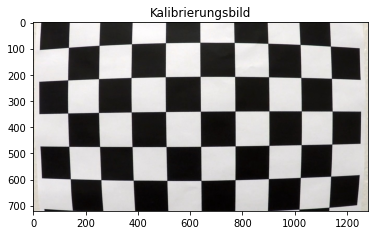

In [140]:
"""
  # Kalibrationsdaten berechnen
  # Der Code liest alle Kalibrationsbilder ein und fügt alle entnommenen Daten zusammen
"""
# Einlesen und Anzeigen eines Beispielbildes
img_cal_1 = cv.cvtColor(cv.imread('./img/Udacity/calib/calibration1.jpg'), cv.COLOR_BGR2RGB)
showimg(img_cal_1, 'Kalibrierungsbild')

# Alle Pfade der Kalibrierbilder laden
calibration_paths = glob.glob('./img/Udacity/calib/*.jpg')

# Gefundene markante Punkte und Objektpunkte definieren
calib_points = []
obj_points = []
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Für alle Kalibrationsbilder durchführen
for path in calibration_paths:
    img = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB)
    #Markante Eckpunkte finden und gegebenenfalls abspeichern
    ret, points = cv.findChessboardCorners(img, (9, 6), None) #9 innere Kanten horizontal, 6 vertikal

    if ret:
        calib_points.append(points)
        obj_points.append(objp)

In [141]:
"""
  # Funktion zur Berechnung der Kamerakalibrierung:
  # Diese wird nur einmal zu Beginn durchgeführt um die Performance zu erhöhen, 
  # danach wird mit der resultierenden Map jedes Frame geremappt und so entzerrt
"""
def calibrate():
  size_1 = (1280,720) #Größe der Bilder definieren (schneller als automatisch zu bestimmen)
  #Kameraparameter berechnen
  _, mtx, dist, _, _ = cv.calibrateCamera(obj_points, calib_points, size_1, None, None)
  newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, size_1, 0, size_1)
  #Map für Entzerrung berechnen
  mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, size_1, 5)
  #Region of interest bestimmen
  x, y, w, h = roi
  #Slices für höhere Performance vorberechnen
  x = slice(x,x+w)
  y = slice(y,y+h)
  return mapx, mapy, x, y

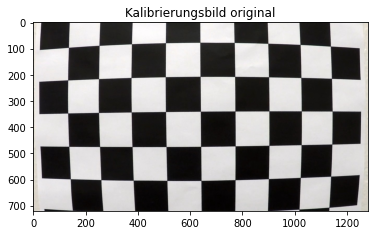

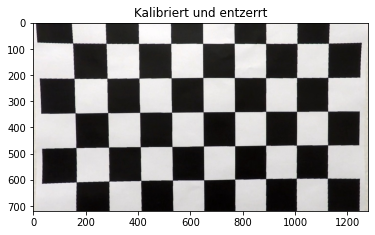

In [142]:
"""
  # Funktion um einzelne Bilder mit berechneter Kalibrierung zu entzerren
"""
def undistort_image(img, mapx, mapy, x, y):
  # Bild remappen, dabei keine (lineare oder kubische) Interpolation sondern nächstes Nachbarpixel verwenden,
  # für bessere Performance 
  undist_img = cv.remap(img, mapx, mapy, cv.INTER_NEAREST)
  # Auf ROI beschneiden
  new_frame = undist_img[y, x]
  return new_frame

# Beispielhaft an erstem Kalibrierungsbild durchgeführt
# Originalbild:
showimg(img_cal_1, 'Kalibrierungsbild original')
mapx, mapy, x, y = calibrate()

# Nach Kalibration, entzerrtes Bild:
img_cal_1_undistorted = undistort_image(img_cal_1, mapx, mapy, x, y)

showimg(img_cal_1_undistorted, 'Kalibriert und entzerrt')

# Exkurs 2: Perspektivtransformation mit Region of Interest
Durch die Kameraperspektive wird die Krümmung der gefundenen Spurmarkierungen nicht der realen Fahrstreifenkrümmung entsprechen. Transformieren Sie daher die Bilder der Kameraperspektive in eine Vogelperspektive, die der realen Fahrstreifenkrümmung entspricht.

In [143]:
"""
  # Funktion um Transformationsmatrizen zwischen den Blickperspektiven zu berechnen
"""
def calc_perspective():
  #Punkte im Originalbild   
  r_1 = [598,448]
  r_2 = [684, 448]
  r_3 = [1026, 668]
  r_4 = [278, 668]
  
  #Punkte aus Vogelperspektive (verbessert für Performance und Qualität)       
  t_1 = [250, 0]
  t_2 = [980, 0]
  t_3 = [980, 629]
  t_4 = [250, 629]
  
  #Array mit Punkten im Originalbild
  input_points = np.float32([(r_1), (r_2), (r_3), (r_4)])
  #Array mit Punkten in Vogelperspektive
  output_points = np.float32([(t_1), (t_2), (t_3), (t_4)])              
  
  #Transformationsmatrix für Normalperspektive -> Vogelperspektive berechnen
  M = cv.getPerspectiveTransform(input_points, output_points)
  #Transformationsmatrix für Vogelperspektive -> Normalperspektiveberechnen
  M_rev = cv.getPerspectiveTransform(output_points, input_points)
  
  return M, M_rev

In [144]:
"""
  # Funktion um Perspektive auf Vogelperspektive zu transformieren und ROI
"""
def transform_perspective(curr_img, M):
  # Region of interest (Himmel wegschneiden) (unnöttig wegen Perspektivtransformation)
  #curr_img[0:400,:,:]=0
  # Größe des Ergebnisbild bestimmen
  curr_img_size = (curr_img.shape[1], curr_img.shape[0])  
  # Perspektive mit Transformationsmatrix M anpassen
  new_warped_img = cv.warpPerspective(curr_img, M, curr_img_size, flags=cv.INTER_NEAREST)
  return new_warped_img

# Aufgabe 3: Erkennung von Fahrbahnmarkierungen

✔ --> Erledigt

☓ --> Nicht Erledigt

Erkennen Sie die Fahrbahnmarkierungen bzw. Fahrstreifen auf den Bildquellen von Udacity. Wenden Sie dabei die aus der Vorlesung bekannten Verfahren an. Gerne dürfen Sie auch weitere Verfahren aus anderen Quellen verwenden. Folgende Ziele müssen bei der finalen Abgabe erreicht werden: 
- ✔ **Segmentierung**: schränken Sie das Bild auf den Bereich ein, in dem sich die Spurmarkierungen befinden

- ✔ **Vorverarbeitung**: führen Sie eine Kamerakalibrierung (für Udacity-Bildquellen) und die Perspektivtransformation durch

- ✔ **Farbräume, Histogramme**: erkennen Sie die Spurmarkierungen in den Farben der angegebenen Quellen. Sofern weitere Spurmarkierungen auf dem Bild gefunden werden, müssen diejenigen Spurmarkierungen priorisiert werden, die die eigene Fahrspur begrenzen

- ✔ **Allgemeines**: Die Verarbeitung von Bildern muss in Echtzeit stattfinden --> Ziel: > 20 FPS

- ✔ **Allgemeines**: Beschleunigen Sie die Verarbeitung durch weitere Maßnahmen weitere Maßnahmen überlegen (bspw. Erkennung der Spurmarkierung in den ersten Frames, Tracking der Spurmarkierung in weiteren Frames solange, bis sich Spurmarkierungspositionen zu stark ändern)

- ✔ **Minimal**: relevante Spurmarkierungen werden im Video "project_video" durchgehend erkannt 

- ☓ **Zusatz**: relevante Spurmarkierungen werden im Video "challenge_video" und "harder_challenge_video" durchgehend erkannt

- ☓ **Zusatz**: relevante Spurmarkierungen werden auf den Datensatz KITTI angewendet. Welche Anpassungen müssen vorgenommen werden, damit Ihr Algorithmus übertragen werden kann?

- ✔ ***Zusatz (bearbeitet siehe Kommentare mit Detailoptimierungen)***: Erarbeiten Sie weitere Maßnahmen zur Geschwindigkeitsverbesserung Ihres Algorithmus
-    LÖSUNG: Caching von Bildern und Vergleich der Bilder

- ☓ **Zusatz**: Erkennen Sie Objekte im Bild und visualisieren Sie diese (z.B. weitere Fahrzeuge, Motorräder, etc.)
Die Objekterkennung bitte so implementieren, dass sie deaktivierbar ist und nicht in FPS-Berechnung einzahlt.

ANMERKUNG: Die Software wurde auf MAC-OS Entwickelt. Eventuell muss auf Windows "cv.waitKey(1)" entfernet werden

# Ablauf

(-0.5, 830.5, 1231.5, -0.5)

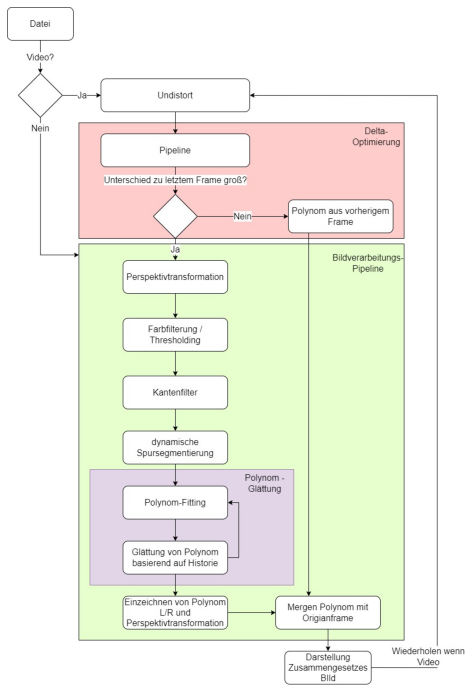

In [145]:
architecture = cv.cvtColor(cv.imread('./img/architecture/Ablauf.jpg'), cv.COLOR_BGR2RGB)
fig,ax = plt.subplots(figsize=(40,10), ncols=1)
ax.imshow(architecture)
fig.tight_layout()
ax.axis('scaled')
plt.axis('off')


# Farbfilterung mit Thresholding

In [146]:
def thresholding(frame):
    """
    # Wendet einen farblichen Threshold auf das Bild an, um relevante Bildbereiche hervorzuheben.
    # Der HSL-Farbraum wird verwendet, um Lightness besser anpassen zu können.
    """
    # Verwendet HLS-Farbraum für bessere Selektierbarkeit
    frame=cv.cvtColor(frame, cv.COLOR_RGB2HLS) 
    # Maske für gelbe Fahrbahnmarkierung
    mask_yellow = cv.inRange(frame, (10, 28, 115), (38, 204, 255))
    # Maske für weiße Linien
    mask_white = cv.inRange(frame, (0, 195, 0), (255, 255, 255)) 

    # Masken elementweise verodern, um kombinierte Maske zu bekommen
    mask_comb=mask_yellow|mask_white
    # Alle Bereiche, die nicht im gewünschten Farbbereich liegen, auf 0 setzen
    frame[np.where(mask_comb==0)] = 0
    global debug
    if debug == 2:  
        cv.imshow("frame",frame)
    return frame

# Line Extraction Laplacian

In [147]:
def line_extraction(frame):
    """
    # Wendet den Laplace- Kantenfilter auf ein Bild @frame an.
    # Entfernt in der Vorverarbeitung Bildrauschen.
    """
    # Opening-Kernel zum entfernen von noise
    opening_kernel=np.array([[0,1,0],[1,1,1],[0,1,0]], 'uint8')
    # Anwenden von Opening-Kernel
    frame = cv.morphologyEx(frame, cv.MORPH_OPEN, opening_kernel, iterations=1)
    # Laplace Kantenfilter stellt besten Kompromiss aus Geschwindigkeit und Genauigkeit dar  
    frame = cv.Laplacian(frame[:,:,0], -1, ksize=7) #Bild filtern
    return frame.astype(np.uint8)
    #return frame[:,:,0].astype(np.uint8)

# Vertikales Segmentieren


In [148]:
def vertical_segmentation(frame, segment_count=3):
  """
  # Vertiakle Segmentierung des Frames 
  # Hierbei wird das Bild in der vertikalen in @segment_count Bereiche unterteilt
  # Für jeden Bereich werden folgende Schritte durchgeführt:
  #   1. Histogram in diesem Bereich bilden
  #   2. Finden einer X-Stellen an der das Bild unterteilt werden kann --> find_segmentation_middle
  #     3.1 Für @return left_lane wird der gesamte Bereich rechts von der X-Stellen auf 0 gesetzt
  #     3.2 Für @return right_lane wird der gesamte Bereich links von der X-Stellen auf 0 gesetzt
  # Die Funktion erzeugt zwei Bilder wobei jeweills nur eine Fahrspur zu erkennen ist
  # Die mehrfache Segmentierung ist bei steilen Kurven und vorallem S-Kurven notwendig
  """
  # Array von X-Stellen an denen das Bild unterteilt
  segmenter_lines=[]

  # COPY um zwei seperate Bilder zu erzeugen
  left_lane=frame.copy()
  right_lane=frame.copy()

  # Berechnung der Y-Koordinaten für die Unterteilung des Bildes
  y=((frame.shape[0]-1)//segment_count)

  # Über alle Bereiche iterieren 
  for line in range(0,segment_count):
    # X-Stellen zwischen den beiden Fahrspuren finden
    x=find_segmentation_middle(frame[line*y:(line+1)*y,:])
    # X-Stelle zu Array hinzufügen
    segmenter_lines.append(x)
    # Alle Intensitätswerte links von der X-Stelle auf 0 setzten --> Nur rechte Fahrspur zu sehen
    right_lane[(line)*y:((line+1)*y),0:x]=0

    # Alle Intensitätswerte links von der X-Stelle auf 0 setzten --> Nur rechte Fahrspur zu sehen
    left_lane[(line)*y:(line+1)*y,x:frame.shape[1]-1]=0
    global debug
    if debug == 3:
      cv.line(frame,(x,(line)*y),(x,(line+1)*y),(255,0,0),2)
  if debug == 3:  
    cv.imshow("frame",frame)
  return left_lane, right_lane

# Poly Fitting

In [149]:
right=[]
left=[]

In [150]:
def smooth_points(original,reference,left_la=True):
    # Berechnung der Änderungsrate zwischen gespeicherten Polynom Gewichten und den neu berechneten Polynomgewichten
    change_rate=1-(np.mean(np.abs(original-reference))*1.6) if 1-(np.mean(np.abs(original-reference))*1.6)>=0 else 0
    # Variablen zum tracken des Fehlers
    global right
    global left
    global debug
    # Fehler für die Linke und Rechte Spur speichern
    if left_la:
        left.append(change_rate)
    else:
        right.append(change_rate)
    if debug == 5:
        return original
    else:
        return change_rate*original+(1-change_rate)*reference
    #

def polyfit(frame, reference):
    """
    # Findet ein Polynom zweiten Grades, dass die Fahrspuren so gut wie möglich als ganzrationale Funktion abbildet
    # Diese Polynom wird in ein schwarzes BGR-Bild eingefügt und zurückgegeben
    # Berechnet die Kurvenradien an den Extremstellen der Polynome links und rechts
    """
    # Erzeugen eines leeren Bildes um die Polynome darin abzuspeichern
    result=np.zeros(shape=(frame.shape[0],frame.shape[1],3),dtype=np.uint8)
    # Die linke und rechte Fahrspur zerteilen --> left_lane=Bild von Linke Fahrspur (rechte Seite 0 gesetzt)
    #                                         --> right_lane=Bild von rechte Fahrspur (linke Seite 0 gesetzt)
    left_lane,right_lane=vertical_segmentation(frame)
    # Finden eines Polynoms 2. Grades, dass die linke Fahrspur beschreibt --> pl ist Polynom, max_val_l-> Extremstelle des Polynoms
    points_left,p_l,max_val_l,koeff_left=poly(left_lane,2,reference[0])
    # Finden eines Polynoms 2. Grades, dass die linke Fahrspur beschreibt --> pr ist Polynom, max_val_r-> Extremstelle des Polynoms
    points_right,p_r,max_val_r,koeff_right=poly(right_lane,2,reference[1],False)

    cv.polylines(result,np.int_([points_left,points_right]),isClosed=False,color=(255,0,0),thickness=25)
    global debug
    if debug == 4:
        cv.polylines(frame,np.int_([points_left,points_right]),isClosed=False,color=(255,0,0),thickness=25)  
        cv.imshow("frame",frame)
    # Kurvenradius berechnen
    # Bildung der Ableitung der Polynome
    pld=np.polyder(p_l)
    prd=np.polyder(p_r)
    # Berechnung des Kurvenradius linke Fahrspur an der Stelle max_val_l. (An der Extremstelle)
    left_curv_rad = (1 + (pld(max_val_l)*2)*1.5) / np.absolute(np.polyder(pld)(max_val_l))
    # Berechnung des Kurvenradius rechte Fahrspur an der Stelle max_val_r. (An der Extremstelle)
    right_curv_rad = (1 + (prd(max_val_r)*2)*1.5) / np.absolute(np.polyder(prd)(max_val_r))
    # Returnt das Bild, in das die Poylnome eingefügt wurden und die Kurvenradien
    return result,left_curv_rad,right_curv_rad,koeff_left,koeff_right

def poly(frame,grad,reference,sd=True):
    """
    # Berechnung des Polynoms für eine Fahrspur
    # Berechnung des Minimums/Maximums (Extremstelle) des Polynoms
    """
    # Lineare Achse für die diskrete Berechnung des Polynoms zweiten Grades
    height_n=np.linspace(0,frame.shape[1],frame.shape[1])
    # Finden der X,Y Koordinaten der Pixel die nicht null sind (Punkte zum Bilden des Polynoms) 
    (zeile,spalte)=np.nonzero(frame)
    # Umrechnungsfaktor von Pixel auf Meter
    x_m_per_pix=30/720
    y_m_per_pix=3.7/700
    # Berechne Polynomgewichte (3 Stück) um Funktion 2.Grades zu berechnen
    polynom = np.polyfit(x_m_per_pix*zeile, y_m_per_pix*spalte, grad)
    if reference is not None:
        polynom=np.poly1d(smooth_points(polynom,reference,sd))
    # Polynome in leeres Bild einzeichnen
    # Berechnen einer Funktion aus den Gewichten --> yn2 = w2_2 * xn**2 + w2_1 * xn + w2_0   
    p = np.poly1d(polynom)
    # Funktion X-Koordinaten in Abhängigkeit von y-Werten (gedrehtes Koordinatensystem und gespiegelt) x(y)
    width_n=p(height_n)
    # Finde die Extremstelle durch finden des minimalen Werts der Ableitung (Analytisch --> 0)
    maxval=np.argmin(np.abs(np.polyder(p)(height_n)))
    # return die Werte des Polynoms (Punktwolke die von dem Polynom beschrieben wird) über das gesamte Bild (Bird View)
    return np.dstack(((1/y_m_per_pix)*width_n,(1/x_m_per_pix)*height_n)).astype(np.uint32),p,maxval,polynom

def find_segmentation_middle(frame):
    """
    # Sucht in einem Histogramm für zwei Spurmarkierungen den Punkt, an dem das Bild am besten getrennt werden kann, 
    # um in jedem Bereich die vollständige Linie zu bewahren. Dazu wird das Bild spaltenweise aufsummiert, sodass 
    # sich zu jedem x-Wert ein kumulierter Helligkeitswert ergibt. Die Linien des Bildes stellen in dieser Form Hochpunkte des Histogramms dar.
    # Um diese zu finden, wird sowohl von links als auch von rechts das Maximum im entstandenen Histogramm gesucht.
    # Das Mittel der beiden so gefundenen x-Werte stellt die beste Segmentierung dar.
    # @returns x-Wert, an dem das Bild segmentiert werden sollte.
    """
    # Kernel für Faltung definieren (normiert auf eins)
    kernel= np.ones(40)
    kernel=kernel/40
    # Kumulierte Summe über Spalten bilden
    summe=np.sum(frame,axis=0)
    # Peaks durch einfache Faltung entfernen
    summe_smooth=np.convolve(summe,kernel,mode='same')

    # Zentren der Peaks initialisieren
    left_center = -1
    right_center= -1

    # Durch kumulierte Summe iterieren
    for i, p in enumerate(summe_smooth):
        # In der Hälfte aufhören, weil dann mit zwei Indizes (rechts, links) das gesamte Bild untersucht wurde
        if i >= len(summe_smooth)//2:
            break
        # Wenn Maximum von links gefunden wird, linkes Zentrum auf Maximum setzen
        if summe_smooth[i + 3] < p and p > summe_smooth[left_center]:
            left_center = i
        # Wenn Maximum von rechts gefunden wird, rechtes Zentrum auf MAximum legen
        if summe_smooth[len(summe_smooth) - i - 4] < summe_smooth[len(summe_smooth) - i - 1] and summe_smooth[len(summe_smooth) - i - 4] > summe_smooth[right_center]:
            right_center = len(summe_smooth) - i

    # Wertebereich für Maxima manuell so einschränken, dass auch bei Fehlern keine Ausreißer entstehen
    if right_center>frame.shape[1]-200:
        right_center=frame.shape[1]-200
    if right_center==-1:
        right_center=frame.shape[1]//2
    if left_center<200:
        left_center=200

    # Maxima von links und rechts mitteln, um optimale Segmentierung zu finden
    segmenter_line = (left_center + right_center)//2
    # Optimale Segmentierung zurückgeben
    return segmenter_line

# Retransform Polylines and merge in original image

In [151]:
def retransform_and_merge(polys,frame,M):
    """
    # Wendet die inverse Perspektivtransformation auf das Bild an, das die Polynome enthält @polys
    # Die eingefärbten und retransformierten Polynome werden dann mit dem Originalbild @frame verbunden
    """
    # wendet Perspektivtransformation auf Polynome an
    polys=transform_perspective(polys,M)
    # fügt die Polynome in das Originalbild ein und gibt dies zurück
    return cv.addWeighted(frame,1,polys,3,0)

# Write Curve-Radius

In [152]:
def write_data(frame,left_curv_rad,right_curv_rad):
    """
    # Schreibt den linken und rechten Kurvenradius auf das Originalbild.
    # Formatierung:
    # Left: <left_curv_rad> m
    # Right: <right_curv_rad> m
    """
    # Schreibe linken Kurvenradius
    cv.putText(frame, f" Left:  {left_curv_rad:.2f} m", (1000, 70), cv.FONT_HERSHEY_SIMPLEX, 1, (100, 255, 0), 1, cv.LINE_AA)
    # Schreibe rechten Kurvenradius
    cv.putText(frame, f" Right: {right_curv_rad:.2f} m", (1000, 140), cv.FONT_HERSHEY_SIMPLEX, 1, (100, 255, 0), 1, cv.LINE_AA)
    return frame

In [153]:
def pipeline(frame,M,M_rev,shortver=False, result=None,left_curv_rad=None,right_curv_rad=None,reference=(None,None)):
    """
    # Kopiert übergebenes Frame und führt dann die notwendigen Schritte zur Linienerkennung durch, dazu gehören:
    # Transformation auf Vogelperspektive, Thresholding, Linienexktraktion, Polynome fitten, 
    """
    org_frame=frame.copy()
    (points_left,points_right) = reference
    if not shortver: #Wenn lange Version
        frame=transform_perspective(frame,M) #Auf Vogelperspektive konvertieren
        global debug
        if debug == 1:  
            cv.imshow("frame",frame)
        frame=thresholding(frame) #Thresholding durchführen
        frame=line_extraction(frame) #Linien extrahieren
        result,left_curv_rad,right_curv_rad,points_left,points_right=polyfit(frame,reference) #Polynome in Bild legen
    frame=retransform_and_merge(polys=result,frame=org_frame,M=M_rev) #Zurück in alte Perspektive konvertieren
    frame=write_data(frame,left_curv_rad,right_curv_rad) # Daten zu Bild hinzufügen
    return frame,result,left_curv_rad,right_curv_rad,points_left,points_right 


# Linienverfolgung

In [154]:
class MemoryThroughTime():
    """
    # Speichert die Frames und Polynome des vorherigen Bildes
    # Berechnet den Unterschied zwischen zwei Bildern
    # Entscheidet anhand einem 'threshold' ob ein neues Polynom berechnet werden soll oder ob das Polynom
    # des vorherigen Bildes verwendet werden kann
    """
    lastframes = [None]
    lastpolys= [None]  
    threshold = 9.0e7
    right_curv_rad = [None]
    left_curv_rad = [None]
    points_left=[None]
    points_right=[None]

    # Replact 
    def replace(self, frame, poly, left_curv_rad, right_curv_rad,points_left,points_right):
        """
        Ersetzt die Daten des vorherigen Frames mit den jetzigen
        """
        frame=cv.cvtColor(frame,cv.COLOR_RGB2GRAY)
        self.lastframes[0]=frame
        self.lastpolys[0]=poly
        self.left_curv_rad[0]=left_curv_rad
        self.right_curv_rad[0]=right_curv_rad
        self.points_left[0]=points_left
        self.points_right[0]=points_right

    def is_big_change(self,frame) -> bool:
        """
        Entscheidet ob es sich um eine große Differenz zwischen dem vorherigen Bild und dem jetzigen handelt
        """
        if(self.lastframes[0] is None):
            return True
        else:
            frame=cv.cvtColor(frame,cv.COLOR_RGB2GRAY)
            return self.threshold< np.sqrt(np.mean(np.square(np.sum(self.lastframes[0][0:400,:]-frame[0:400,:]))))

    def get_data(self):
        """
        Gibt die Daten des aktuell gespeicherten Frames zurück
        """
        return self.lastpolys[0],self.left_curv_rad[0],self.right_curv_rad[0],self.points_left[0],self.points_right[0],

# DEMO

In [155]:
def rundemo(input):
    """
    # Führt alle Hauptschritte zum Lesen und Ausführen der Pipeline durch.
    # Differenziert je nach Input nach Video und Bildverarbeitung
    """
    global debug
    if debug == 6:
        fourcc = cv.VideoWriter_fourcc(*'mp4v')
        out = cv.VideoWriter('output.mp4', fourcc,20, (1279,719))
    # Berechne Perspektivtransformationen für projekt-video (normal und invers)
    M,M_rev=calc_perspective()
    # Wenn der übergebene Pfad ein Bild ist
    if input.split(".")[-1].upper() == "JPG":
        # Lies Bild ein
        frame=cv.imread(input)
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        # Führe Pipeline auf Bild aus
        frame,result,left_curv_rad,right_curv_rad,_,_  = pipeline(frame,M,M_rev)
        frame = cv.cvtColor(frame, cv.COLOR_RGB2BGR)
        # Zeige ERgebnisbild an
        cv.imshow('frame', frame)
        cv.waitKey(0)
        cv.destroyAllWindows()
        cv.waitKey(1)
    # Wenn es sich um ein Video handelt
    elif input.split(".")[-1].upper() == "MP4":
        # Starte Videostream
        vid = cv.VideoCapture(input)
        # Initialwerte für FPS-Berechnung
        prev_frame_time = 0
        new_frame_time = 0
        # Initialisiere Memory - Funktion
        mem=MemoryThroughTime()
        i=0 
        while True:
            i+=1
            # Neues Frame auslesen
            ret, frame = vid.read()
            # if ret False dann ist das Video vrobei
            if ret == False:
                break
            # Von BGR zu RGB konvertieren
            frame=cv.cvtColor(frame, cv.COLOR_BGR2RGB)
            # Kameratransformationsmatrix auf das Frame anwenden, um Distortion zu entfernen
            frame=undistort_image(frame,mapx,mapy,x,y)
            # Wenn es einen großen Unterschied zwischen konsekutiven Frames gibt oder jedes zweite Bild
            if mem.is_big_change(frame) or i%2==1:
                # Führe Pipeline auf frame aus
                _,_,_, points_left ,points_right=mem.get_data()
                frame,result,left_curv_rad,right_curv_rad,points_left,points_right = pipeline(frame,M,M_rev, reference=(points_left ,points_right))
                mem.replace(frame,result,left_curv_rad, right_curv_rad,points_left,points_right)
            else:
                # Ansonsten führe verkürzte Version der Pipeline mit Polynom aus vorherigem Frame aus
                result,left_curv_rad,right_curv_rad,_,_=mem.get_data()
                frame,result,left_curv_rad,right_curv_rad,points_left,points_right = pipeline(frame,M,M_rev,shortver=True,result=result,left_curv_rad=left_curv_rad,right_curv_rad=right_curv_rad)
            # Zurück zu BGR konvertieren
            frame=cv.cvtColor(frame, cv.COLOR_RGB2BGR)
            # Zeige FPS an
            font = cv.FONT_HERSHEY_SIMPLEX
            # Zeit bei Beenden des Berechnungsschritts
            new_frame_time = time.time()
        
            #Jeden zweiten Schritt die FPS ausrechnen
            if i%2==1:
                fps = 1/(new_frame_time-prev_frame_time)*2.0
                prev_frame_time=new_frame_time

            # FPS umrechnen für Anzeige
            fps = int(fps)
            fps = str(fps)

            # Schreibe FPS auf Hauptbild
            cv.putText(frame, fps, (7, 70), font, 3, (100, 255, 0), 3, cv.LINE_AA)

            # Zeige Frame an
            if debug == 0 or debug == 5:
                cv.imshow('frame', frame)
            if debug == 6:
                out.write(frame)
            # Abbruch, wenn q gedrückt wird
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
            
        # Beenden, wenn Video zuende ist oder unterdrückt wird
        vid.release()
        if debug == 6:
            out.release()
        cv.destroyAllWindows()
        cv.waitKey(1)

In [156]:
path_projectvid="./img/Udacity/project_video.mp4"
path_projectvid_challenge="./img/Udacity/challenge_video.mp4"
path_projectvid_challenge_hard="./img/Udacity/harder_challenge_video.mp4"
example_img='./img/Udacity/image004.jpg'
# debug0 --> fertiges Projekt
# debug1 --> Nach Perspektiv Transformation 
# debug2 --> Nach Thresholding
# debug3 --> Segmentation der Fahrspuren
# debug4 --> Polynom in Bird View reingelegt
# debug5 --> OHNE line smoothing
# debug6 --> Export Video
debug=0
rundemo(input=path_projectvid)

# Angewandt auf Einzelbilder

In [157]:
"""
  # Funktion um Einzelbilder zu Verarbeiten
  # Bilder mit beliebiger Taste weiterdrücken
"""
def detect(img, M, M_rev):
    i = 1
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB) #Farbraum konvertieren
    img = pipeline(img,i,M,M_rev) #Bild durch Pipeline für Erkennung
    return img
    
imgs = glob.glob('./img/Udacity/*.jpg') #Pfade zur allen Einzelbildern ermitteln 
M,M_rev=calc_perspective() #Transformationsmatrizen berechnen (Hin- und Rücktransformation)

#Für alle Bilder Erkennung durchführen und Bilder anzeigen
global debug
if debug ==0:
  for i in range(0,len(imgs)):
      rundemo(imgs[i])

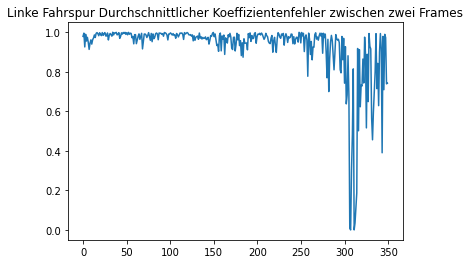

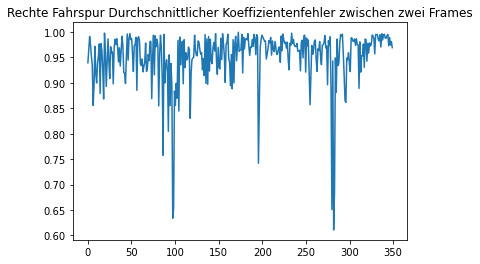

In [158]:
# Anzeigen der Change Rate zwischen den berechneten Polynomen
df= np.linspace(0,len(right),len(right))
df2= np.linspace(0,len(left),len(left))
plt.title("left lane average coefficient error  between two frames")
plt.plot(df,left)
plt.show()
plt.title("right lane average coefficient error  between two frames")
plt.plot(df2,right)
plt.show()